In [1]:

import sys
import sys
sys.path.append("../")
import src.soporte as sp
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geoapiExercises")
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date
import re
pd.options.display.max_columns = None

c:\Users\smico\anaconda3\envs\iron\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
df = pd.read_csv('datos/volunteers_1v.csv', low_memory=False)
#Utilizamos low memory=False ya que al leerlo me daba un error porque en algunas columnas tienen diferentes tipos de datos, habrá que echarle un vistazo
df.head(5)

,Name,Course,Anglo Status,Date Modified,Age,Birth Date,Veteran,Gender,Nationality,Request Status,Date Modified.1,Arrival Medium,Arrival Company,Arrival Number,Travel_Alone
0,Andrew Thomas,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Bad feedback,26/01/2022 13:21,20.0,NaN,Yes,Male,IRELAND,Cleared,27/02/2019 14:35,NaN,NaN,NaN,No
1,Emily Harmon,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Approved,02/12/2019 10:21,21.0,NaN,Yes,Female,UNITED KINGDOM,Cleared,20/03/2019 12:47,NaN,NaN,NaN,No
2,Norma Nelson,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Approved,12/05/2021 12:02,20.0,NaN,Yes,Female,CANADA,Veteran,22/05/2019 18:18,NaN,NaN,NaN,No
3,Sandra Gonzales,Zujar TEENS - 2 weeks - July/2/2017 to July/15...,Approved,09/03/2022 12:19,21.0,NaN,Yes,Female,IRELAND,Cleared,11/05/2017 14:43,NaN,NaN,NaN,No
4,Annette Robinson,Zujar TEENS - 2 weeks - July/2/2017 to July/15...,Approved,22/06/2021 23:03,23.0,NaN,Yes,Female,USA,Cleared,24/04/2017 14:05,NaN,NaN,NaN,No


In [3]:
print(df.columns)

Index(['Name', 'Course', 'Anglo Status', 'Date Modified', 'Age', 'Birth Date',
       'Veteran', 'Gender', 'Nationality ', 'Request Status',
       'Date Modified.1', 'Arrival Medium', 'Arrival Company',
       'Arrival Number', 'Travel_Alone'],
      dtype='object')


In [4]:
# Reemplaza los espacios por subrayados en los nombres de las columnas
df.columns= df.columns.str.lstrip()
df.columns= df.columns.str.rstrip()
df.columns = df.columns.str.replace(" ", "_")
df.head(2)

,Name,Course,Anglo_Status,Date_Modified,Age,Birth_Date,Veteran,Gender,Nationality,Request_Status,Date_Modified.1,Arrival_Medium,Arrival_Company,Arrival_Number,Travel_Alone
0,Andrew Thomas,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Bad feedback,26/01/2022 13:21,20.0,NaN,Yes,Male,IRELAND,Cleared,27/02/2019 14:35,NaN,NaN,NaN,No
1,Emily Harmon,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Approved,02/12/2019 10:21,21.0,NaN,Yes,Female,UNITED KINGDOM,Cleared,20/03/2019 12:47,NaN,NaN,NaN,No


In [5]:
df.shape

(91108, 15)

In [6]:
df.isnull().sum()

Name                   0
Course                 0
Anglo_Status         744
Date_Modified        742
Age                  742
Birth_Date         90366
Veteran             4496
Gender                 0
Nationality            0
Request_Status       742
Date_Modified.1      742
Arrival_Medium     90927
Arrival_Company    90928
Arrival_Number     90995
Travel_Alone           0
dtype: int64

In [7]:
#cambiamos los nulos de Anglo_Status a TBC y Veterano a "no"
df["Anglo_Status"].fillna("TBC", inplace=True)
df['Veteran'].fillna("No",inplace=True)


In [8]:
#Queremos comprobar si todos los nulos de determinadas columnas están en las mismas filas
df_comparativa_nulos=df[['Date_Modified','Age','Request_Status','Date_Modified.1']]
#sumamos los nulos por filas, axis=1
filas_na = df_comparativa_nulos[['Date_Modified', 'Age', 'Request_Status','Date_Modified.1']].isnull().sum(axis=1)
#creamos una nueva variable que almacena las filas que cumplen con la condicion de que el numero de nulos por fila sea 4
coincide = filas_na[filas_na == 4]
print(f'Tenemos {coincide} filas que tienen 4 nulos, por lo cual es cierto que todos los nulos se situan en las mismas filas')

Tenemos 90366    4
90367    4
90368    4
90369    4
90370    4
        ..
91103    4
91104    4
91105    4
91106    4
91107    4
Length: 742, dtype: int64 filas que tienen 4 nulos, por lo cual es cierto que todos los nulos se situan en las mismas filas


In [9]:
#Calculamos el porcentaje que representan los nulos
columnas_nulos = ['Date_Modified', 'Age', 'Request_Status', 'Date_Modified.1']
for col in columnas_nulos:
    porcentaje = round((df[col].isnull().sum() / df.shape[0]) * 100, 2)
    print(f"El porcentaje de valores nulos en la columna '{col}' es: {porcentaje}%")

El porcentaje de valores nulos en la columna 'Date_Modified' es: 0.81%
El porcentaje de valores nulos en la columna 'Age' es: 0.81%
El porcentaje de valores nulos en la columna 'Request_Status' es: 0.81%
El porcentaje de valores nulos en la columna 'Date_Modified.1' es: 0.81%


In [10]:
#Eliminamos los nulos, pero lo almacenamos en un nuevo dataframe para mantener el dataframe original
df2=df.dropna(subset='Date_Modified')
nulos=df.shape[0]-df2.shape[0]
print(f'La diferencia entre el dataframe anterior y el nuevo es de {nulos}, que es el número de nulos que teniamos en las columnas analizadas')


La diferencia entre el dataframe anterior y el nuevo es de 742, que es el número de nulos que teniamos en las columnas analizadas


In [11]:
#Creamos un nuevo dataframe con aquellos datos de llegada
df_arrivals=df[df['Arrival_Number'].isnull() == False]
df_arrivals.head(2)

,Name,Course,Anglo_Status,Date_Modified,Age,Birth_Date,Veteran,Gender,Nationality,Request_Status,Date_Modified.1,Arrival_Medium,Arrival_Company,Arrival_Number,Travel_Alone
90367,David Blevins,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/02/...,TBC,NaN,NaN,17/06/2004,Yes,Male,USA,NaN,NaN,Plane,Delta Airlines,DL126,No
90373,Ann Bowman,La Alberca TEENS-VOLUNTEER 2 WEEKS from 07/09/...,TBC,NaN,NaN,10/10/2006,Yes,Female,USA,NaN,NaN,Plane,American Airlines,AA94,No


In [12]:
#Eliminamos las columnas que tienen mayría de nulos para que el dataframe quede más legible
df2.drop(['Arrival_Medium','Arrival_Company','Arrival_Number','Birth_Date'],axis=1,inplace=True)
df2.head(2)

C:\Users\smico\AppData\Local\Temp\ipykernel_16428\361397941.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2.drop(['Arrival_Medium','Arrival_Company','Arrival_Number','Birth_Date'],axis=1,inplace=True)


,Name,Course,Anglo_Status,Date_Modified,Age,Veteran,Gender,Nationality,Request_Status,Date_Modified.1,Travel_Alone
0,Andrew Thomas,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Bad feedback,26/01/2022 13:21,20.0,Yes,Male,IRELAND,Cleared,27/02/2019 14:35,No
1,Emily Harmon,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Approved,02/12/2019 10:21,21.0,Yes,Female,UNITED KINGDOM,Cleared,20/03/2019 12:47,No


In [13]:
df2.isnull().sum()

Name               0
Course             0
Anglo_Status       0
Date_Modified      0
Age                0
Veteran            0
Gender             0
Nationality        0
Request_Status     0
Date_Modified.1    0
Travel_Alone       0
dtype: int64

In [14]:
#Necesitamos una columna extra con los años en que los voluntarios han aplicado o asistido a los campamentos. La vamos a sacar del nombre de los curso
#Extraemos los años de la fecha de programa y lso añadimos a una columna nueva
df2['Year'] = df2['Course'].str.extract(r'(\d{4})')
#Calculamos el porcentaje de nulos en la nueva columna
porcentaje=sp.porcentaje_nulos(df2,'Year')
print(f'El porcentaje de años nulos es de {porcentaje}%')

El porcentaje de años nulos es de 3.04%


C:\Users\smico\AppData\Local\Temp\ipykernel_16428\1496820249.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Year'] = df2['Course'].str.extract(r'(\d{4})')


In [15]:
#Sustituimos los nulos por el valor siguiente
df2['Year'].fillna(method='ffill', inplace=True)
df2['Year'].isnull().sum()

C:\Users\smico\AppData\Local\Temp\ipykernel_16428\3402033954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['Year'].fillna(method='ffill', inplace=True)


0

Ya lo tenemos sin nulos, vamos a analizar la información.

In [16]:
#Valores únicos
df2.apply(pd.Series.nunique)

Name               12612
Course              1088
Anglo_Status          17
Date_Modified      24768
Age                   86
Veteran                2
Gender                 2
Nationality          188
Request_Status        18
Date_Modified.1    41700
Travel_Alone           1
Year                  16
dtype: int64

In [17]:
import warnings
warnings.filterwarnings("ignore")
#La primera vez que hemos corrido el código nos ha dado un error así que usamos la libreria Warnings
#Eliminamos los duplicados de la columna 'Name'
df_unicos = df2.drop_duplicates(subset='Name', inplace=False)
df_unicos.head(2)


,Name,Course,Anglo_Status,Date_Modified,Age,Veteran,Gender,Nationality,Request_Status,Date_Modified.1,Travel_Alone,Year
0,Andrew Thomas,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Bad feedback,26/01/2022 13:21,20.0,Yes,Male,IRELAND,Cleared,27/02/2019 14:35,No,2019
1,Emily Harmon,Zujar TEENS - 2 weeks - June/30/2019 to July/1...,Approved,02/12/2019 10:21,21.0,Yes,Female,UNITED KINGDOM,Cleared,20/03/2019 12:47,No,2019


In [18]:
df_unicos.drop(['Course','Anglo_Status','Date_Modified','Request_Status','Date_Modified.1','Travel_Alone'],axis=1,inplace=True)
df_unicos.head(2)

,Name,Age,Veteran,Gender,Nationality,Year
0,Andrew Thomas,20.0,Yes,Male,IRELAND,2019
1,Emily Harmon,21.0,Yes,Female,UNITED KINGDOM,2019


In [19]:
df_unicos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12612 entries, 0 to 90293
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         12612 non-null  object 
 1   Age          12612 non-null  float64
 2   Veteran      12612 non-null  object 
 3   Gender       12612 non-null  object 
 4   Nationality  12612 non-null  object 
 5   Year         12612 non-null  object 
dtypes: float64(1), object(5)
memory usage: 689.7+ KB


In [20]:
df_unicos['Age'].astype(int)


0        20
1        21
2        20
3        21
4        23
         ..
89311    63
89558    72
89679    59
90187    59
90293    73
Name: Age, Length: 12612, dtype: int32

In [21]:
df_unicos.to_csv("datos/voluntarios_unicos.csv",index=False, header=True)

In [22]:
df_unicos.isnull().sum()

Name           0
Age            0
Veteran        0
Gender         0
Nationality    0
Year           0
dtype: int64

In [23]:
#Hipotesis1: el mayor grupo de voluntarios pertenece al grupo de 41-60, tanto en aplicaciones como en voluntarios reales
#Vamos a crear dos dataframes, uno que solo contenga los veteranos y otro con todos pero solo las columnas necesarias, en los casos necesitamos que sean mayores de 18
#Seleccionamos aquellos que son mayores de 18
df_edad_reales = df_unicos[df_unicos['Age'] >= 18]
print(df_edad_reales['Age'].sort_values())
df_edad_totales=df2[df2['Age']>=18]
df_edad_totales.drop(['Course','Anglo_Status','Date_Modified','Request_Status','Date_Modified.1','Travel_Alone'],axis=1,inplace=True)
print(df_edad_totales['Age'].sort_values())


2936     18.0
4233     18.0
4302     18.0
4342     18.0
3311     18.0
         ... 
1506     94.0
1459     94.0
67095    94.0
23473    94.0
1715     98.0
Name: Age, Length: 12588, dtype: float64
21223    18.0
108      18.0
4270     18.0
4272     18.0
53490    18.0
         ... 
87336    95.0
1752     98.0
1715     98.0
52801    99.0
52133    99.0
Name: Age, Length: 90307, dtype: float64


In [24]:
#Creamos grupos de edad y los asignamos 
bins_age = [17, 25, 40, 60, 75, df['Age'].max()]
labels_age = ['18-25', '26-40', '41-60', '61-75', '76+']
df_edad_reales['Age_Group'] = pd.cut(df_edad_reales['Age'], bins=bins_age, labels=labels_age)
df_edad_totales['Age_Group'] = pd.cut(df_edad_totales['Age'], bins=bins_age, labels=labels_age)


In [25]:
#Vamos a ver si se ha generado algun nulo en alguno de los campos
print(df_edad_reales.isna().sum())
print(df_edad_totales.isna().sum())


Name           0
Age            0
Veteran        0
Gender         0
Nationality    0
Year           0
Age_Group      0
dtype: int64
Name           0
Age            0
Veteran        0
Gender         0
Nationality    0
Year           0
Age_Group      0
dtype: int64


In [26]:
mediana_age_reales=df_edad_reales['Age'].median()
mediana_age_totales=df_edad_totales['Age'].median()

In [27]:
#La primera comprobacion será entre los grupos de edades por aplicaciones y reales. >Les separamos en dos dtaframes que usaremos para las gráficas
age_groups_real = df_edad_reales.groupby(['Age_Group']).size().reset_index(name='Total')
age_groups_total= df_edad_totales.groupby(['Age_Group']).size().reset_index(name='Total')


In [28]:
#Llamamos a la función porcentaje que está guardada en soporte.py
age_groups_real['Porcentaje']=sp.porcentaje(age_groups_real,'Total')
age_groups_total['Porcentaje']=sp.porcentaje(age_groups_total,'Total')
print(age_groups_real)
print(age_groups_total)

  Age_Group  Total  Porcentaje
0     18-25   1799       14.29
1     26-40   5495       43.65
2     41-60   2382       18.92
3     61-75   2391       18.99
4       76+    521        4.14
  Age_Group  Total  Porcentaje
0     18-25  10010       11.08
1     26-40  34833       38.57
2     41-60  17688       19.59
3     61-75  21231       23.51
4       76+   6545        7.25


'for i, bar in enumerate(ax.patches):\n   ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()  +1.5,\n        f"{gender_groups[\'Porcentaje\'][i]}",\n        horizontalalignment= \'center\', verticalalignment=\'bottom\',\n        fontsize=15, rotation=0, color=\'black\')'

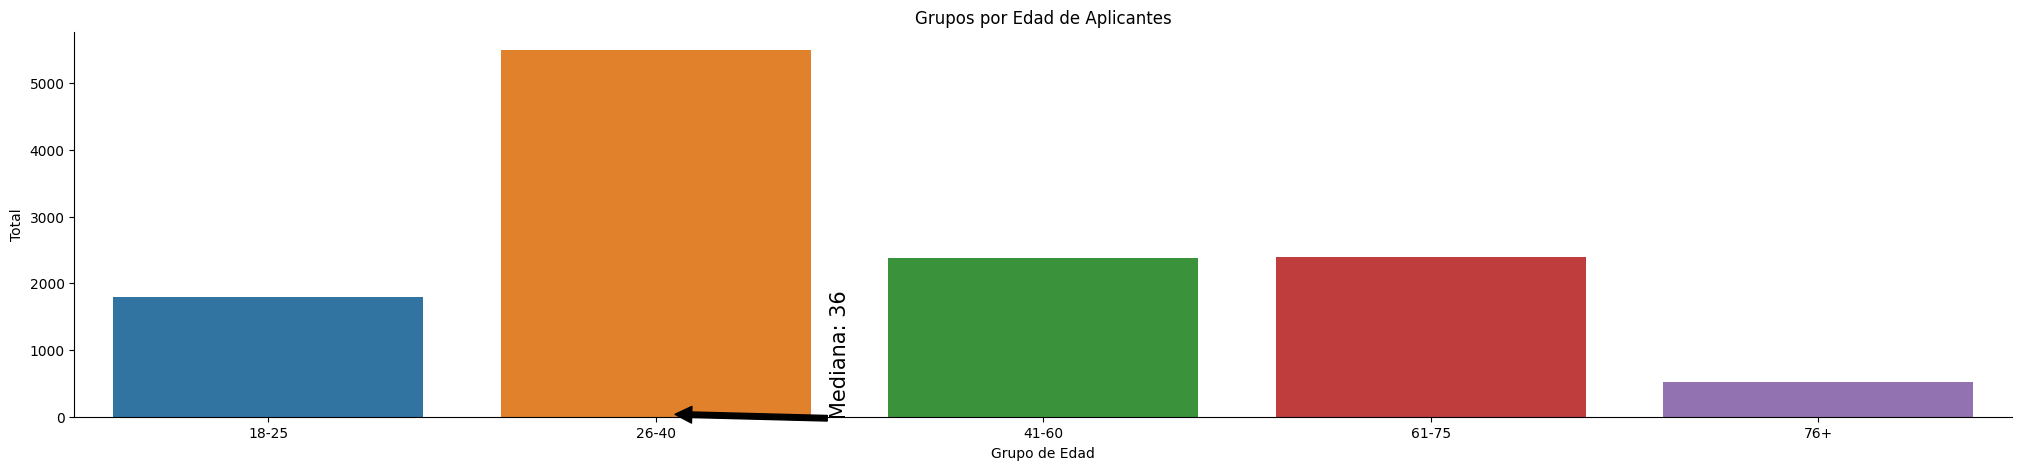

In [50]:
sp.graf_barras(mediana_age_reales,'Age_Group', 'Total', age_groups_real,'Grupo de Edad', 'Total','Grupos por Edad de Aplicantes')

"""for i, bar in enumerate(ax.patches):
   ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()  +1.5,
        f"{gender_groups['Porcentaje'][i]}",
        horizontalalignment= 'center', verticalalignment='bottom',
        fontsize=15, rotation=0, color='black')"""

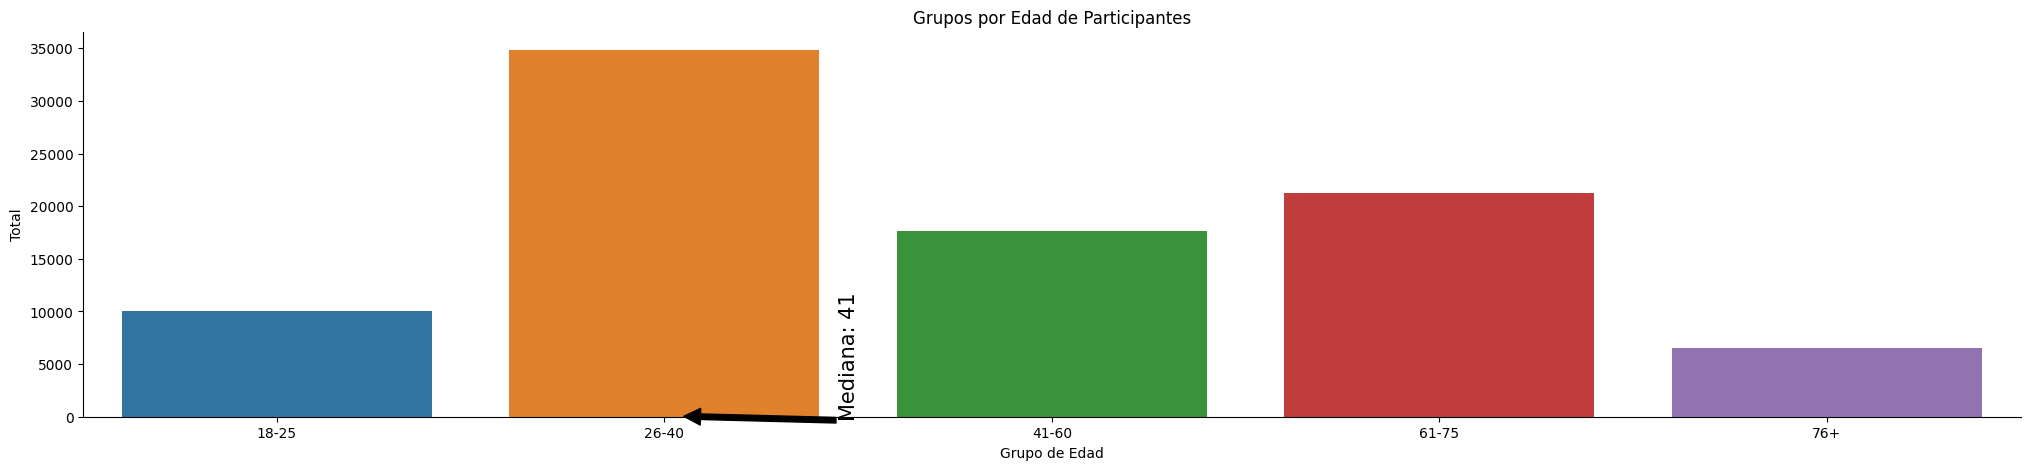

In [49]:
sp.graf_barras(mediana_age_totales,'Age_Group', 'Total', age_groups_total,'Grupo de Edad', 'Total','Grupos por Edad de Participantes')

In [31]:

timeline_age_real=df_edad_reales.groupby(['Year', 'Age_Group']).sum()
timeline_age_real=timeline_age_real.reset_index()
timeline_age_real.columns=['Year','Age_Group','Total']
timeline_age_totales=df_edad_totales.groupby(['Year', 'Age_Group']).sum()
timeline_age_totales=timeline_age_totales.reset_index()
timeline_age_totales.columns=['Year','Age_Group','Total']
print(timeline_age_real)
print(timeline_age_totales)



    Year Age_Group   Total
0   2004     18-25   215.0
1   2004     26-40    69.0
2   2004     41-60   171.0
3   2004     61-75   696.0
4   2004       76+   318.0
..   ...       ...     ...
70  2023     18-25   127.0
71  2023     26-40    61.0
72  2023     41-60  1034.0
73  2023     61-75  2272.0
74  2023       76+   474.0

[75 rows x 3 columns]
    Year Age_Group    Total
0   2004     18-25   2134.0
1   2004     26-40   2430.0
2   2004     41-60   7339.0
3   2004     61-75  18157.0
4   2004       76+   9236.0
..   ...       ...      ...
75  2023     18-25    669.0
76  2023     26-40   2339.0
77  2023     41-60   6793.0
78  2023     61-75  21184.0
79  2023       76+   2741.0

[80 rows x 3 columns]


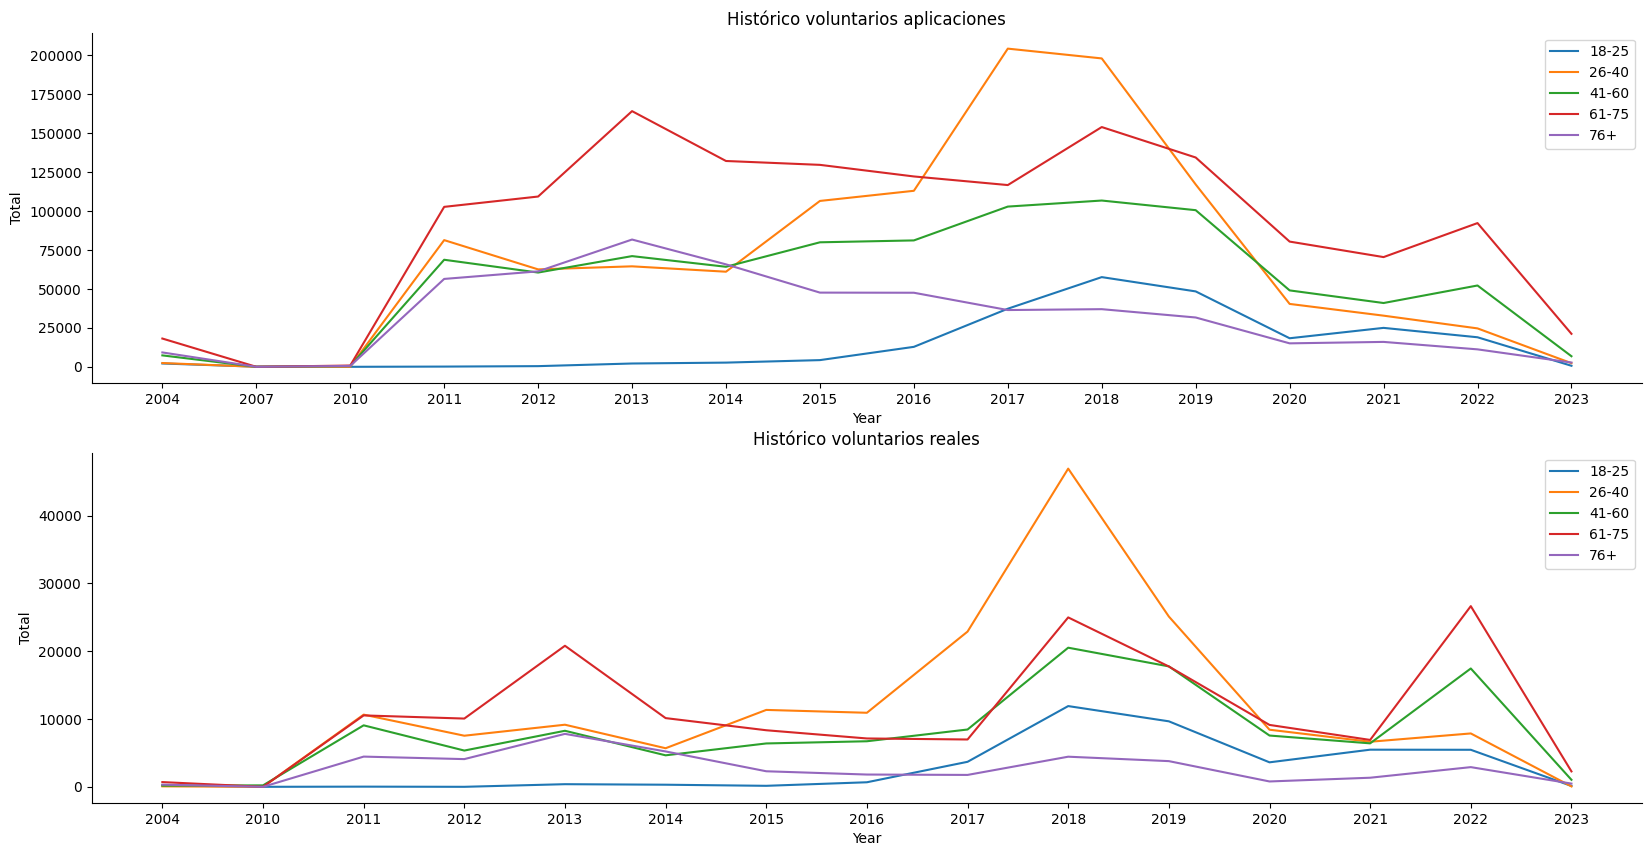

In [32]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
plt.subplot(2, 1, 1)
for group in timeline_age_totales['Age_Group'].unique():
    subset = timeline_age_totales[timeline_age_totales['Age_Group'] == group]
    plt.plot(subset['Year'], subset['Total'], label=group)
plt.xlabel('Year')
plt.ylabel('Total')
plt.legend()
plt.title('Histórico voluntarios aplicaciones')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Crear el segundo gráfico
plt.subplot(2, 1, 2)
for group in timeline_age_real['Age_Group'].unique():
    subset = timeline_age_real[timeline_age_real['Age_Group'] == group]
    plt.plot(subset['Year'], subset['Total'], label=group)
plt.xlabel('Year')
plt.ylabel('Total')
plt.legend()
plt.title('Histórico voluntarios reales')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Mostrar los gráficos
plt.show()





In [33]:
try:
    location = geolocator.geocode("Ireland")
    continent = location.raw.get('address').get('continent')
    print(continent)
except:
    continent = None
    print("Location not found")

Location not found


In [34]:
df_paises_real=df_unicos.groupby(['Nationality']).size().reset_index(name='Total')
df_paises_total=df2.groupby(['Nationality']).size().reset_index(name='Total')
df_paises_total

,Nationality,Total
0,ABU DHABI,6
1,AFGHANISTAN,27
2,ALBANIA,76
3,ALGERIA,725
4,AMERICAN SAMOA,95
...,...,...
183,VIETNAM,48
184,WEST INDIES,12
185,YEMEN,42
186,ZAMBIA,67


In [35]:
df_paises_real['Porcentaje']=sp.porcentaje(df_paises_real,'Total')
df_paises_total['Porcentaje']=sp.porcentaje(df_paises_total,'Total')
df_paises_real.sort_values (by='Porcentaje',ascending=False)


,Nationality,Total,Porcentaje
151,USA,5435,43.09
148,UNITED KINGDOM,1691,13.41
30,CANADA,1043,8.27
67,INDIA,846,6.71
10,AUSTRALIA,369,2.93
...,...,...,...
98,MOZAMBIQUE,1,0.01
79,KOREA,1,0.01
81,KYRGYZSTAN,1,0.01
91,MALDIVES,1,0.01


In [36]:
df_paises_total.sort_values (by='Porcentaje',ascending=False)

,Nationality,Total,Porcentaje
179,USA,40348,44.65
175,UNITED KINGDOM,15042,16.65
38,CANADA,8323,9.21
85,INDIA,4881,5.40
89,IRELAND,2896,3.20
...,...,...,...
48,COOK ISLANDS,3,0.00
34,BURKINA FASO,2,0.00
84,ICELAND,2,0.00
39,CANAL ZONE,3,0.00


In [37]:
df_paises_total['Nationality_groups']=np.where(df_paises_total['Porcentaje']<2,'OTHERS',df_paises_total['Nationality'])
df_paises_real['Nationality_groups']=np.where(df_paises_real['Porcentaje']<2,'OTHERS',df_paises_real['Nationality'])
df_paises_total


,Nationality,Total,Porcentaje,Nationality_groups
0,ABU DHABI,6,0.01,OTHERS
1,AFGHANISTAN,27,0.03,OTHERS
2,ALBANIA,76,0.08,OTHERS
3,ALGERIA,725,0.80,OTHERS
4,AMERICAN SAMOA,95,0.11,OTHERS
...,...,...,...,...
183,VIETNAM,48,0.05,OTHERS
184,WEST INDIES,12,0.01,OTHERS
185,YEMEN,42,0.05,OTHERS
186,ZAMBIA,67,0.07,OTHERS


In [40]:
df_paises_real=pd.DataFrame(df_paises_real.groupby(['Nationality_groups'])['Porcentaje','Total'].sum()).reset_index().sort_values(by='Porcentaje',ascending=False)
df_paises_total=pd.DataFrame(df_paises_total.groupby(['Nationality_groups'])['Porcentaje','Total'].sum()).reset_index().sort_values(by='Porcentaje',ascending=False)
df_paises_total

,Nationality_groups,Porcentaje,Total
6,USA,44.65,40348
4,OTHERS,17.86,16164
5,UNITED KINGDOM,16.65,15042
1,CANADA,9.21,8323
2,INDIA,5.40,4881
3,IRELAND,3.20,2896
0,AUSTRALIA,3.00,2712


In [39]:
df_paises_total = df_paises_total.reset_index(drop=True)
df_paises_real = df_paises_real.reset_index(drop=True)

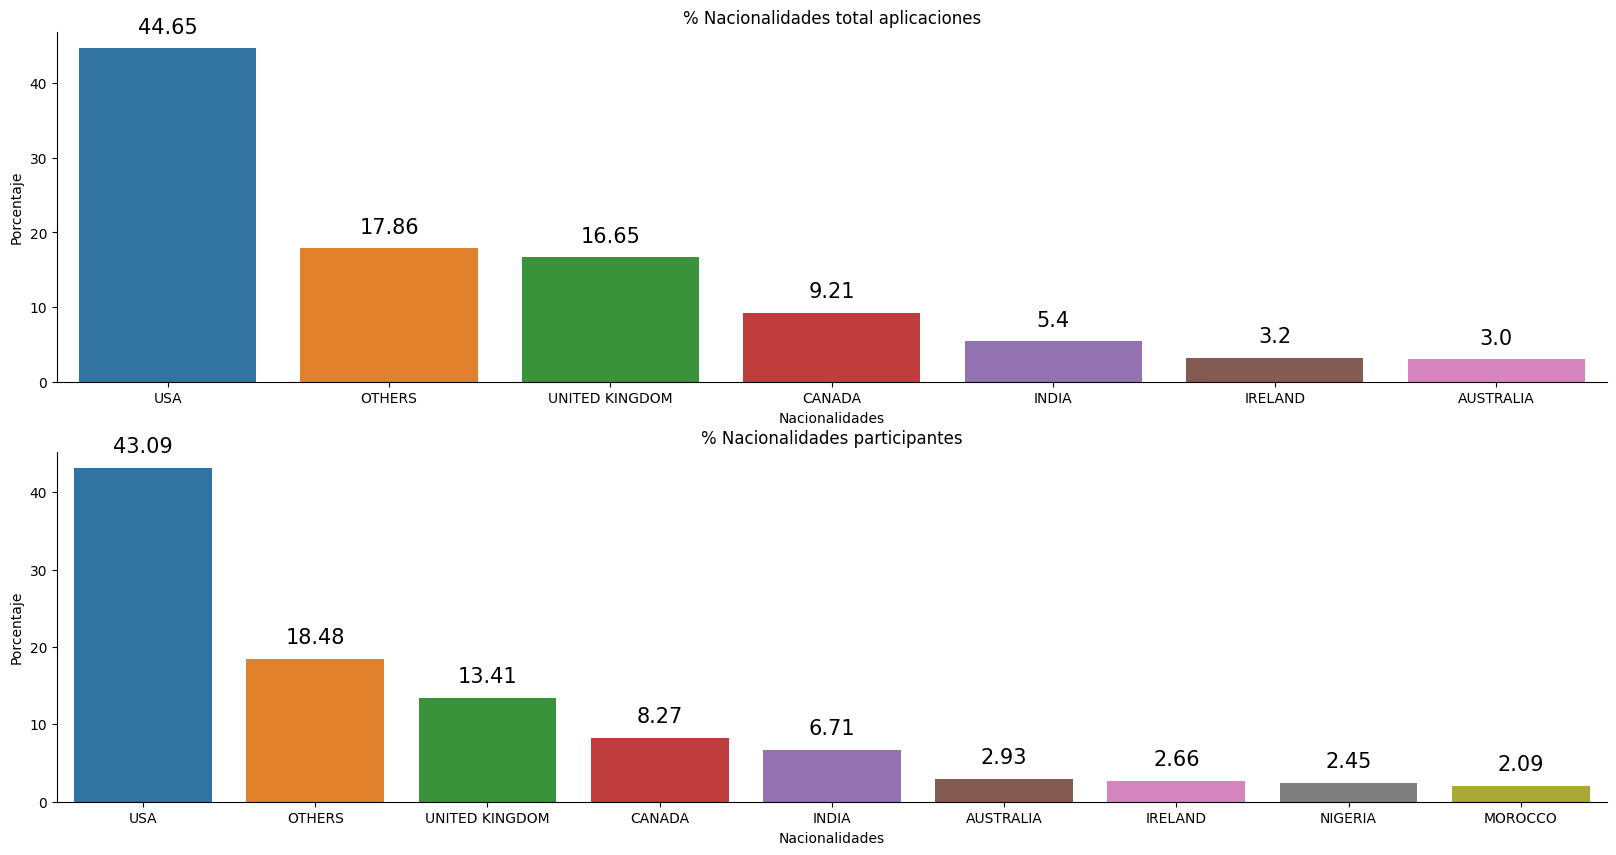

In [40]:
# Create bar chart
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
plt.subplot(2, 1, 1)

ax = sns.barplot(x='Nationality_groups', y='Porcentaje', data=df_paises_total)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add value labels to the bars
for i, bar in enumerate(ax.patches):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() +1.5,
        f"{df_paises_total['Porcentaje'][i]}",
        horizontalalignment='center', verticalalignment='bottom',
        fontsize=15, rotation=0, color='black')

# Add x and y labels and title
plt.xlabel('Nacionalidades')
plt.ylabel('Porcentaje')
plt.title('% Nacionalidades total aplicaciones')


plt.subplot(2, 1, 2)
ax = sns.barplot(x='Nationality_groups', y='Porcentaje', data=df_paises_real)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Add value labels to the bars
for i, bar in enumerate(ax.patches):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() +1.5,
        f"{df_paises_real['Porcentaje'][i]}",
        horizontalalignment='center', verticalalignment='bottom',
        fontsize=15, rotation=0, color='black')

# Add x and y labels and title
plt.xlabel('Nacionalidades')
plt.ylabel('Porcentaje')
plt.title('% Nacionalidades participantes')

plt.show()





In [44]:
df_paises_reales_historico=df_unicos.groupby(['Nationality','Year']).reset_index()
df_paises_totales_historico=df2.groupby(['Nationality','Year']).reset_index()


In [47]:
df_paises_reales_historico['Porcentaje']=sp.porcentaje(df_paises_reales_historico,'Total')
df_paises_totales_historico['Porcentaje']=sp.porcentaje(df_paises_totales_historico,'Total')
df_paises_reales_historico.sort_values (by='Porcentaje',ascending=False)
df_paises_totales_historico.sort_values (by='Porcentaje',ascending=False)

KeyError: 'Column not found: Total'

In [46]:
df_paises_reales_historico['Nationality_groups']=np.where(df_paises_reales_historico['Porcentaje']<2,'OTHERS',df_paises_reales_historico['Nationality'])
df_paises_totales_historico['Nationality_groups']=np.where(df_paises_totales_historico['Porcentaje']<2,'OTHERS',df_paises_totales_historico['Nationality'])
df_paises_totales_historico

KeyError: 'Column not found: Porcentaje'

In [ ]:


df_paises_reales_historico = pd.DataFrame(df_paises_reales_historico.groupby(['Nationality_groups'])
                      ['Porcentaje','Total'].sum()).reset_index()

df_paises_totales_historico = pd.DataFrame(df_paises_totales_historico.groupby(['Nationality_groups'])
                      ['Porcentaje','Total'].sum()).reset_index()

df_paises_reales_historico.sort_values(by='Porcentaje',ascending=False)
df_paises_totales_historico.sort_values(by='Porcentaje',ascending=False)

In [ ]:
"""age_groups = df_edad.groupby(['Age_Group','Gender']).size().reset_index(name='Total')
gender_groups=pd.DataFrame(df_edad.groupby(['Gender'])['Name'].count()).reset_index()
gender_groups.rename({'Name': 'Total'}, axis=1, inplace=True)

gender_groups['Porcentaje']=(gender_groups['Total'] /gender_groups['Total'].sum())
gender_groups["Porcentaje"] = gender_groups["Porcentaje"].apply(lambda x: format(x, '.0%'))

gender_groups"""

In [ ]:
counts = df['Identificador'].value_counts()

# Iterar sobre cada elemento de la columna "Identificador"
for i, elemento in df['Identificador'].iteritems():
    # Comprobar si el elemento en la columna "Veteran" es nulo
    if pd.isnull(df.loc[i, 'Veteran']):
        # Comprobar si el elemento aparece más de una vez
        if counts[elemento] > 1:
            # Asignar 'Yes' a la columna "Veteran"
            df.loc[i, 'Veteran'] = 'Yes'
        else:
            # Asignar 'No' a la columna "Veteran"
            df.loc[i, 'Veteran'] = 'No'

df



In [ ]:

nulos= df['Year'].isnull().sum()
print(f'Tenemos {nulos} valores nulos en la columna "Year"')
df_years_na = df.loc[df['Year'].isna()]
unique_courses = df_years_na['Course'].unique()
print(f'Los valores únicos para "Course" en las filas donde "Year" es nulo son: {unique_courses}')

In [ ]:
df['Year'] = df['Course'].str.extract(r'(\d{4})')
df


In [ ]:
print(df.isnull().sum())

In [ ]:
df_nulos_año=df[df['Year'].isnull() == True]
df.to_csv("datos/voluntarios_total.csv",index=False, header=True)

In [ ]:
len(df_nulos_año['Course'].unique())

In [ ]:

df_unicos=df_unicos[['Identificador','Age', 'Birth_Date', 'Gender', 'Nationality']]
df_unicos['Age']=df['Age'].astype(int)
df_unicos = df.drop_duplicates(subset='Identificador', inplace=False)
df_unicos['Birth_Date']=df['Birth_Date'].astype(int)
df_edad = df_unicos[["Identificador","Age","Nationality","Gender"]]

df_unicos.to_csv("datos/voluntarios_unicos.csv",index=False, header=True)

In [ ]:
age_median = df_edad['Age'].median()

sp.graf_barras_2(age_median,'Age_Group', 'Total',age_groups,'Grupo de Edad', 'Total','Grupos de Edad y Género','Gender','Total',gender_groups,'Gender', 'Total', 'Género')

"""for i, bar in enumerate(ax.patches):
   ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()  +1.5,
        f"{gender_groups['Porcentaje'][i]}",
        horizontalalignment= 'center', verticalalignment='bottom',
        fontsize=15, rotation=0, color='black')"""

In [ ]:
#hipotesis covid
df_años=pd.DataFrame(df.groupby(['Year'])['Identificador'].count()).reset_index()
df_años.rename({'Identificador': 'Total'}, axis=1, inplace=True)
df_años

In [ ]:
df_años['Year'] = df_años['Year'].astype(int)


In [ ]:
bins = [2010, 2019, 2020, df_años['Year'].max()]
labels = ['Pre-Covid (2011-2019)', 'Covid (2020)', 'Post-Covid(2020-2022']
df_años['Covid_Group'] = pd.cut(df_años['Year'], bins=bins, labels=labels)

df_años

In [ ]:
df_años = df_años.dropna(subset=["Covid_Group"])
df_años.drop([15], axis=0, inplace=True)
df_años.reset_index
df_años

In [ ]:
sp.graf_lineal(df_años,'Year','Total','Year','Total Volunteers','Year','COVID Effect',2020)

"""Add text labels
plt.text(2013, 8030, 'Pre-Covid', rotation=90,  fontsize=20)
plt.text(2021, 8030, 'Post-Covid', rotation=90, fontsize=20)"""

In [ ]:
df_nacionalidad = pd.DataFrame(df_unicos.groupby(['Nationality'])
                      ["Identificador"].count()).reset_index()

df_nacionalidad.rename({'Identificador': 'Numero_personas'}, axis=1, inplace=True)

df_nacionalidad['Porcentaje']=sp.porcentaje(df_nacionalidad,'Numero_personas')

df_nacionalidad['Nationality_groups']=np.where(df_nacionalidad['Porcentaje']<2,'OTHERS',df_nacionalidad['Nationality'])

df_nacionalidad_grupos = pd.DataFrame(df_nacionalidad.groupby(['Nationality_groups'])
                      ['Porcentaje','Numero_personas'].sum()).reset_index()

df_nacionalidad_grupos.sort_values(by='Porcentaje',ascending=False)

df_nacionalidad_grupos

In [ ]:
#Hipotesis2: Más del 50% son americanos

df_nacionalidad = pd.DataFrame(df_unicos.groupby(['Nationality'])
                      ["Identificador"].count()).reset_index()

df_nacionalidad.rename({'Identificador': 'Numero_personas'}, axis=1, inplace=True)

df_nacionalidad['Porcentaje']=(df_nacionalidad['Numero_personas'] /df_nacionalidad['Numero_personas'].sum())*100



df_nacionalidad['Nationality_groups']=np.where(df_nacionalidad['Porcentaje']<2,'OTHERS',df_nacionalidad['Nationality'])
print(df_nacionalidad)

df_nacionalidad_grupos = pd.DataFrame(df_nacionalidad.groupby(['Nationality_groups'])
                      ['Porcentaje','Numero_personas'].sum()).reset_index()

df_nacionalidad_grupos.sort_values(by='Porcentaje',ascending=False)

In [ ]:
df_nacionalidad_otros=df_nacionalidad[df_nacionalidad['Nationality_groups']=='OTHERS']
df_nacionalidad_otros.sort_values(by='Porcentaje',ascending=False)

In [ ]:
df_nacionalidad_otros['Country']=df_nacionalidad_otros['Nationality'].str.title()
df_nacionalidad_otros.head(2)

In [ ]:
df_paises = pd.read_csv('datos/paises.csv')
df_paises= df_paises.drop(['ISO_Code','M49_Code', 'Region1', 'Region2'], axis=1)
df_paises

In [ ]:

df_nacionalidad_otros=df_nacionalidad_otros.merge(df_paises, how='left', on='Country')
df_nacionalidad_otros

In [ ]:
df_nacionalidad_otros= df_nacionalidad_otros.drop(['Nationality_groups'], axis=1)
df_nacionalidad_otros

In [ ]:
df_nacionalidad_otros['Continent'].isnull().sum()

In [ ]:
df_nacionalidad_otros_nulos=df_nacionalidad_otros[df_nacionalidad_otros['Continent'].isnull() == True]
len(df_nacionalidad_otros_nulos['Nationality'])

In [ ]:
df_nacionalidad_otros_nulos.drop(['Continent'], axis=1, inplace=True)

In [ ]:
from fuzzywuzzy import fuzz

# Iterar sobre las filas del dataframe df_nacionalidades
for index, row in df_nacionalidad_otros_nulos.iterrows():
  pais = row['Country']
  max_similarity = 0
  match = None
  
  # Iterar sobre las filas del dataframe df_paises
  for index_df_paises, row_df_paises in df_paises.iterrows():
    country = row_df_paises['Country']
    
    # Calcular el parecido entre las dos cadenas de texto
    similarity = fuzz.token_set_ratio(pais, country)
    
    # Si el parecido es mayor que 50 y mayor que el máximo encontrado hasta ahora, actualizar la variable temporal
    if similarity > 80 and similarity > max_similarity:
      max_similarity = similarity
      match = country
  
  # Si se ha encontrado una coincidencia con parecido mayor que 50, actualizar la columna ciudad_origen en el dataframe df_ciudades
  if match is not None:
    df_nacionalidad_otros_nulos.loc[index, 'Country'] = match

df_nacionalidad_otros_nulos.head(2)

In [ ]:
df_nacionalidad_otros_nulos=df_nacionalidad_otros_nulos.merge(df_paises, how='left', on='Country')

df_nacionalidad_otros_nulos.head(2)


In [ ]:
df_nacionalidad_otros_nulos['Continent'].isnull().sum()

In [ ]:
df_nacionalidad_otros_nulos2=df_nacionalidad_otros_nulos[df_nacionalidad_otros_nulos['Continent'].isnull() == True]

df_nacionalidad_otros_nulos2


In [ ]:
pais=df_nacionalidad_otros_nulos2['Country'].tolist()
pais_equivalencia=['Other','Other','Other', 'Other', 'Other', 'Czechia', 'Other', 'Other', "Democratic People's Republic of Korea", 'Republic of Moldova', 'Other', 'Other', 'Russian Federation', 'Somalia', 'Other', 'Other','Syrian Arab Republic', 'China', 'Other', 'Viet Nam', 'Other']
pais_dict={}

for key,value in zip(pais,pais_equivalencia):
    pais_dict[key]=value

print(pais_dict)

In [ ]:
df_nacionalidad_otros_nulos2=df_nacionalidad_otros_nulos2.replace({'Country':pais_dict})

df_nacionalidad_otros_nulos2

In [ ]:
df_nacionalidad_otros_nulos2.drop(['Continent'], axis=1, inplace=True)
df_nacionalidad_otros_nulos2

In [ ]:
df_nacionalidad_otros_nulos2=df_nacionalidad_otros_nulos2.merge(df_paises[['Country','Continent']],how='left', on='Country')

df_nacionalidad_otros_nulos2

In [ ]:
df_nacionalidad_otros_nulos2.isnull().sum()

In [ ]:
len(df_nacionalidad_otros['Country'])

In [ ]:
df_nacionalidad_otros['Continent'].isnull().sum()

In [ ]:
df_nacionalidad_otros=df_nacionalidad_otros.dropna(subset=['Continent'])
df_nacionalidad_otros_nulos=df_nacionalidad_otros_nulos.dropna(subset=['Continent'])
df_nacionalidad_otros=pd.concat([df_nacionalidad_otros,df_nacionalidad_otros_nulos,df_nacionalidad_otros_nulos2],axis=0)

len(df_nacionalidad_otros['Country'])
df_nacionalidad_otros['Continent'].isnull().sum()

In [ ]:
df_continente = pd.DataFrame(df_nacionalidad_otros.groupby(['Continent'])
                      ["Numero_personas"].sum()).reset_index()


df_continente['Porcentaje']=(df_continente['Numero_personas'] /df_continente['Numero_personas'].sum())*100


df_continente.sort_values(by='Porcentaje',ascending=False)

In [ ]:
df_nacionalidad_grupos.sort_values(by=['Porcentaje'])

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplots_adjust(wspace=3.5)

explode = (0.1, 0.1, 0.1, 0.4, 0.1, 0.3, 0.1)
explode2=(0.1, 0.4, 0.2, 0.1, 0.3, 0.5, 0.1)

plt.subplot(1, 2, 1)
plt.pie(df_nacionalidad_grupos['Porcentaje'], 
    labels = df_nacionalidad_grupos['Nationality_groups'], 
    autopct = '%1.1f%%', 
    radius=3,
    explode=explode
)
plt.legend(bbox_to_anchor = (-1, 3))
plt.title("Países que representan más de un 2%", y=2.5)

plt.subplot(1, 2, 2)
plt.pie(df_continente['Porcentaje'], 
    labels = df_continente['Continent'], 
    autopct = '%1.1f%%', 
    radius=3,
    explode=explode2
)
plt.legend(bbox_to_anchor = (3, 3))
plt.title("Distribución por continente del resto", y=2.5)


In [ ]:
df_veterans=df.groupby(['Identificador'])['Course'].count().reset_index()
print(df_veterans['Course'].sum())

df_veterans.rename({'Course':'Repeat'},axis=1,inplace=True)
df_veterans


In [ ]:
bins = [0, 1, 5, 10, df_veterans['Repeat'].max()]
labels = ['1', '2-5', '6-10', '+10']
df_veterans['Veterans_Group'] = pd.cut(df_veterans['Repeat'], bins=bins, labels=labels)

df_veterans

In [ ]:
df_veteran_group= df_veterans.groupby(['Veterans_Group']).count().reset_index()
df_veteran_group['Porcentaje']= (df_veteran_group['Repeat']/df_veteran_group['Repeat'].sum())
df_veteran_group["Porcentaje"] = df_veteran_group["Porcentaje"].apply(lambda x: format(x, '.0%'))

df_veteran_group

In [ ]:
plt.figure(figsize=(10, 5))

ax = sns.barplot(x='Veterans_Group', y='Repeat', data=df_veteran_group)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Añadir etiquetas y título al gráfico
plt.xlabel('Returning volunteers')
plt.ylabel('Total')
plt.title('Veterans')
for i, bar in enumerate(ax.patches):
   ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height()  +1.5,
        f"{df_veteran_group['Porcentaje'][i]}",
        horizontalalignment= 'center', verticalalignment='bottom',
        fontsize=15, rotation=0, color='black')

# Mostrar el gráfico
plt.show()

In [ ]:
df.dtypes
df['Year'] = df['Year'].astype(int)

df_2021 = df[df['Year'] == 2021].copy()
df_2021


In [ ]:
import re

# Crear una expresión regular para buscar "TEENS" o "TEEN"
pattern = re.compile("TEENS|TEEN", re.IGNORECASE)

# Seleccionar las filas donde la columna "Course" contiene el patrón
df_teens_2021 = df_2021[df_2021['Course'].str.contains(pattern)]
df_teens_2021

In [ ]:
cursos=df_teens_2021["Course"].unique()

serie_cursos = pd.Series(cursos).reset_index(drop=True)
serie_cursos

In [ ]:
serie_cursos.drop([6], axis=0, inplace=True)
serie_cursos

In [ ]:
serie_cursos=sp.dividir_serie(serie_cursos)

In [ ]:
serie_cursos.to_csv("datos/cursos_teens.csv",index=False, header=True)